Loading libraries

In [ ]:
pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

import networkx as nx

Functions for independence testing

In [ ]:
def is_indep(arr_1, arr_2, threshold=0.01, verbose=False):
    diff = arr_1.mean() * arr_2.mean() - (arr_1 * arr_2).mean()
    if verbose:
        print(diff)
    return abs(diff) < threshold

def is_cond_independent(data_df, var_1, var_2, cond_set):
    # create a copy with different combinations of values in cond_set
    data_df_tmp = data_df.copy()
    tmp_arr = data_df_tmp[cond_set[0]].astype(str).values
    for el in cond_set[1:]:
        tmp_arr += ' ' + data_df_tmp[el].astype(str)
    data_df_tmp['cond'] = tmp_arr

    # get unique combinations of values in cond_set
    cond_vals = data_df_tmp['cond'].unique()

    # for every possible combination check if we have independence
    for cond_val in cond_vals:
        tmp_df = data_df_tmp[data_df_tmp['cond'] == cond_vals[0]]
        if not is_indep(tmp_df[var_1].values, tmp_df[var_2].values):
            return False
    return True

# Generating data

For data generation we will be using python package [`causalgraphicalmodels`](https://github.com/ijmbarr/causalgraphicalmodels)

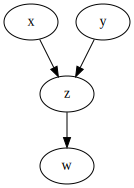

In [ ]:
fd0 = StructuralCausalModel({
    "x": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "y": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "z": discrete_model(["x", "y"], {
        (0,0): (0.1,0.9,), 
        (0,1): (0.3,0.7,),
        (1,0): (0.8,0.2,),
        (1,1): (0.9,0.1,),
        }),
    "w": discrete_model(["z"],{
        (0,): (0.8,0.2,),
        (1,): (0.1,0.9,), 
    })
})

fd0.cgm.draw()

Now we can sample data from the generated model

In [ ]:
n_samples=1000000
# n_samples=1000
data_df = fd0.sample(n_samples=n_samples)

# Step 1. Fully connected graph

In [ ]:
all_nodes = ['x', 'y', 'z', 'w']
nodes_pos = {'x': (1, 5), 'y': (5, 5), 'z': (1, 1), 'w': (5, 1)}

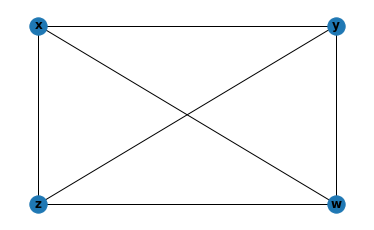

In [ ]:
G = nx.Graph()
G.add_nodes_from(all_nodes)
#G.add_nodes_from(tuple(zip(all_nodes, nodes_pos)))

for i in range(0, len(all_nodes)):
    node_1 = all_nodes[i]
    for j in range(i+1, len(all_nodes)):
        node_2 = all_nodes[j]
        G.add_edge(node_1, node_2)

plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

# Step 2. Test unconditional independence

In [ ]:
for i in range(0, len(all_nodes)):
    var_1 = all_nodes[i]
    for j in range(i + 1, len(all_nodes)):
        var_2 = all_nodes[j]
        # testStat, thresh = hsic_gam(data_df[var_1].values.reshape(-1, 1), data_df[var_2].values.reshape(-1, 1), alph=alph)
        # print(testStat, thresh)
        print("{} and {} are independent: {}".format(var_1, var_2, 
                                                     is_indep(data_df[var_1].values, data_df[var_2].values)))

x and y are independent: True
x and z are independent: False
x and w are independent: False
y and z are independent: False
y and w are independent: False
z and w are independent: False


Removing edge between $X$ and $Y$

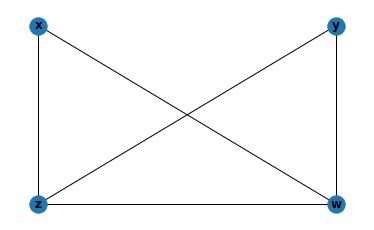

In [ ]:
G.remove_edge('x', 'y')
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

# Step 3. Condition on 1 variable
For each pair of variables ($A$, $B$) having an edge between them, and for each variable $C$ with an edge connected to either of them, eliminate the edge between $A$ and $B$ if $\left(A ⊥⊥ B\right) | C$ 

In [ ]:
combinations = [
                ('x', 'z', 'w'), ('x', 'z', 'y'), 
                ('y', 'w', 'z'), ('y', 'w', 'x'),
                ('z', 'w', 'x'), ('z', 'w', 'y'),
                ('x', 'w', 'z'), ('x', 'w', 'y'),
                ('y', 'z', 'x'), ('y', 'z', 'w'),
                ]

In [ ]:
for var_1, var_2, cond_var in combinations:
    print('{} and {} are independent given {} = {}'.format(
        var_1, var_2, cond_var, is_cond_independent(data_df, var_1, var_2, [cond_var])
    ))

x and z are independent given w = False
x and z are independent given y = False
y and w are independent given z = True
y and w are independent given x = False
z and w are independent given x = False
z and w are independent given y = False
x and w are independent given z = True
x and w are independent given y = False
y and z are independent given x = False
y and z are independent given w = False


Removing edges between $Y$ and $W$ and between $X$ and $W$

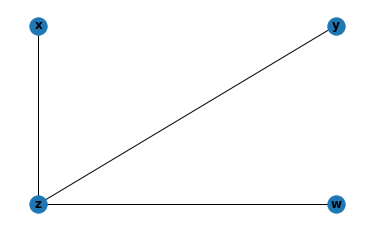

In [ ]:
G.remove_edge('y', 'w')
G.remove_edge('x', 'w')
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

# Step 4. ...

# Step 5. Search for v-structure

Consider 3 cases:
1. $W - Z - Y$
2. $W - Z - X$
3. $X - Z - Y$

3-d case can be oriented as $X -> Z <- Y$

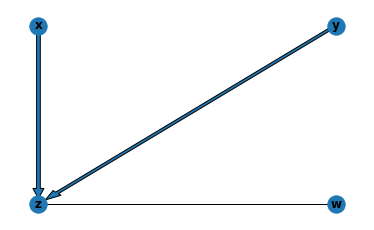

In [ ]:
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

plt.arrow(1, 5, 0, -3.65, width=0.05)       # X - > Z
plt.arrow(5, 5, -3.75, -3.75, width=0.05)   # Y - > Z

# Step 6. Orientation propagation

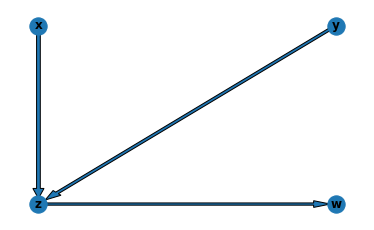

In [ ]:
plt.figure(figsize=(5, 3))
nx.draw(G, pos=nodes_pos, with_labels=True, font_weight='bold')

plt.arrow(1, 5, 0, -3.65, width=0.05)       # X - > Z
plt.arrow(5, 5, -3.75, -3.75, width=0.05)   # Y - > Z
plt.arrow(1, 1, 3.7, 0, width=0.05)   # Z - > W

# Excercise 1:

Simulate PC algorithm for the following graph (as in the example above)

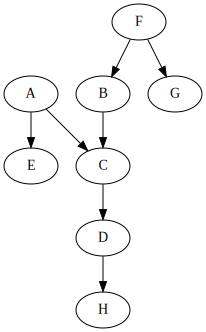

In [ ]:
fd0 = StructuralCausalModel({
    "A": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "F": lambda n_samples: np.random.binomial(n=1, p=0.4, size=n_samples),
    "E": discrete_model(["A"],{
        (0,): (0.6,0.4,),
        (1,): (0.1,0.9,), 
    }),
    "G": discrete_model(["F"],{
        (0,): (0.1,0.9,),
        (1,): (0.8,0.2,), 
    }),
    "B": discrete_model(["F"],{
        (0,): (0.3,0.7,),
        (1,): (0.6,0.4,), 
    }),
    "C": discrete_model(["A", "B"], {
        (0,0): (0.1,0.9,), 
        (0,1): (0.3,0.7,),
        (1,0): (0.8,0.2,),
        (1,1): (0.4,0.6,),
        }),
    "D": discrete_model(["C"],{
        (0,): (0.1,0.9,),
        (1,): (0.9,0.1,), 
    }),
    "H": discrete_model(["D"],{
        (0,): (0.6,0.4,), 
        (1,): (0.9,0.1,),
    })
})

fd0.cgm.draw()

In [ ]:
n_samples=1000000
# n_samples=1000
data_df2 = fd0.sample(n_samples=n_samples)

## Fully connected graph

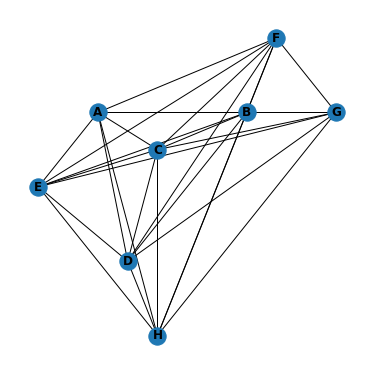

In [ ]:
all_nodes2 = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
nodes_pos2 = {'A': (2,4), 'B': (4.5,4), 'C': (3,3.5), 'D': (2.5,2), 'E': (1,3), 
             'F': (5,5), 'G': (6,4), 'H': (3,1)}

G2 = nx.Graph()
G2.add_nodes_from(all_nodes2)
#G.add_nodes_from(tuple(zip(all_nodes, nodes_pos)))

for i in range(0, len(all_nodes2)):
    node_1 = all_nodes2[i]
    for j in range(i+1, len(all_nodes2)):
        node_2 = all_nodes2[j]
        G2.add_edge(node_1, node_2)

plt.figure(figsize=(5, 5))
nx.draw(G2, 
        pos=nodes_pos2, 
        with_labels=True, font_weight='bold')

# Test unconditional independence

In [ ]:
L = [] #Define an empty set to add the unconditionally independent nodes to remove it afterwards

In [ ]:
for i in range(0, len(all_nodes2)):
    var_1 = all_nodes2[i]
    for j in range(i + 1, len(all_nodes2)):
        var_2 = all_nodes2[j]
        # testStat, thresh = hsic_gam(data_df[var_1].values.reshape(-1, 1), data_df[var_2].values.reshape(-1, 1), alph=alph)
        # print(testStat, thresh)
        print("{} and {} are independent: {}".format(var_1, var_2, 
                                                     is_indep(data_df2[var_1].values, data_df2[var_2].values)))
        if is_indep(data_df2[var_1].values,data_df2[var_2].values):
          L.append((var_1,var_2)) #append the unconditionally independent nodes to L 

A and B are independent: True
A and C are independent: False
A and D are independent: False
A and E are independent: False
A and F are independent: True
A and G are independent: True
A and H are independent: False
B and C are independent: False
B and D are independent: False
B and E are independent: True
B and F are independent: False
B and G are independent: False
B and H are independent: True
C and D are independent: False
C and E are independent: False
C and F are independent: True
C and G are independent: True
C and H are independent: False
D and E are independent: False
D and F are independent: True
D and G are independent: True
D and H are independent: False
E and F are independent: True
E and G are independent: True
E and H are independent: False
F and G are independent: False
F and H are independent: True
G and H are independent: True


Remove the edges that are unconditionally independent:

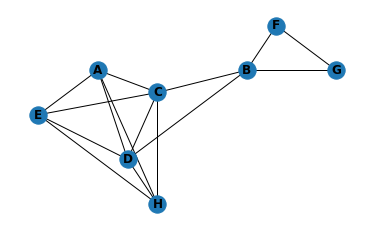

In [ ]:
for i in range(0,len(L)):
  G2.remove_edge(L[i][0],L[i][1])
plt.figure(figsize=(5, 3))
nx.draw(G2, pos=nodes_pos2, with_labels=True, font_weight='bold')

# Condition on one variable

Find all the combinations possible 

In [ ]:
edges = list(G2.edges())

In [ ]:
nodes = list(G2.nodes())

In [ ]:
def combinations(): #Find all of the combinations 
  combinations = []
  for i in edges: #For every edge
    for j in [x for p,x in enumerate(nodes) if (x!= i[0] and x != i[1])]:#for every node except the ones in the i-th edge
      if G2.has_edge(j,i[0]) or G2.has_edge(j,i[1]): #if j is adjacent to any of the i[0] or i[1]
        combinations.append((i[0],i[1],j)) #put in the combinations set
      else:
        pass
  return combinations          

In [ ]:
combinations2 = combinations()

In [ ]:
combinations2

[('A', 'C', 'B'),
 ('A', 'C', 'D'),
 ('A', 'C', 'E'),
 ('A', 'C', 'H'),
 ('A', 'D', 'B'),
 ('A', 'D', 'C'),
 ('A', 'D', 'E'),
 ('A', 'D', 'H'),
 ('A', 'E', 'C'),
 ('A', 'E', 'D'),
 ('A', 'E', 'H'),
 ('A', 'H', 'C'),
 ('A', 'H', 'D'),
 ('A', 'H', 'E'),
 ('B', 'C', 'A'),
 ('B', 'C', 'D'),
 ('B', 'C', 'E'),
 ('B', 'C', 'F'),
 ('B', 'C', 'G'),
 ('B', 'C', 'H'),
 ('B', 'D', 'A'),
 ('B', 'D', 'C'),
 ('B', 'D', 'E'),
 ('B', 'D', 'F'),
 ('B', 'D', 'G'),
 ('B', 'D', 'H'),
 ('B', 'F', 'C'),
 ('B', 'F', 'D'),
 ('B', 'F', 'G'),
 ('B', 'G', 'C'),
 ('B', 'G', 'D'),
 ('B', 'G', 'F'),
 ('C', 'D', 'A'),
 ('C', 'D', 'B'),
 ('C', 'D', 'E'),
 ('C', 'D', 'H'),
 ('C', 'E', 'A'),
 ('C', 'E', 'B'),
 ('C', 'E', 'D'),
 ('C', 'E', 'H'),
 ('C', 'H', 'A'),
 ('C', 'H', 'B'),
 ('C', 'H', 'D'),
 ('C', 'H', 'E'),
 ('D', 'E', 'A'),
 ('D', 'E', 'B'),
 ('D', 'E', 'C'),
 ('D', 'E', 'H'),
 ('D', 'H', 'A'),
 ('D', 'H', 'B'),
 ('D', 'H', 'C'),
 ('D', 'H', 'E'),
 ('E', 'H', 'A'),
 ('E', 'H', 'C'),
 ('E', 'H', 'D'),
 ('F', 'G'

Removing the ones which are conditionally independent

In [ ]:
C = []
for var_1, var_2, cond_var in combinations2:
    print('{} and {} are independent given {} = {}'.format(
        var_1, var_2, cond_var, is_cond_independent(data_df2, var_1, var_2, [cond_var])
    ))
    if is_cond_independent(data_df2,var_1,var_2,[cond_var]):
      C.append((var_1,var_2))

A and C are independent given B = False
A and C are independent given D = False
A and C are independent given E = False
A and C are independent given H = False
A and D are independent given B = False
A and D are independent given C = True
A and D are independent given E = False
A and D are independent given H = False
A and E are independent given C = False
A and E are independent given D = False
A and E are independent given H = False
A and H are independent given C = True
A and H are independent given D = True
A and H are independent given E = False
B and C are independent given A = False
B and C are independent given D = False
B and C are independent given E = False
B and C are independent given F = False
B and C are independent given G = False
B and C are independent given H = False
B and D are independent given A = False
B and D are independent given C = True
B and D are independent given E = False
B and D are independent given F = False
B and D are independent given G = False
B an

In [ ]:
len(C) #the length should be 12, (sometimes it is 14 or 13 but when I run everything again it becomes 12)

12

In [ ]:
S = set(C) #remove the duplicates from the list
C = list(S)

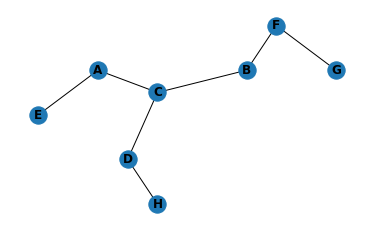

In [ ]:
for i in range(0,len(C)): #Finding the skeleton
  G2.remove_edge(C[i][0],C[i][1])
plt.figure(figsize=(5, 3))
nx.draw(G2, pos=nodes_pos2, with_labels=True, font_weight='bold')

Finding all the triples possible from the nodes:

In [ ]:
nodes

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

In [ ]:
triples = []
for i in nodes:
  for j in [x for x in nodes if x != i]:
    for k in [x for x in nodes if x != i and x != j]:
      triples.append((i,j,k))

In [ ]:
len(triples) #it should be 8*7*6 = 336

336

Here I defined a directed graph to orient some of the edges according to the PC algorithm

# Search for V-structures

In [ ]:
G3 = nx.DiGraph()
G3.add_nodes_from(all_nodes2)

In [ ]:
for i in triples:
  if G2.has_edge(i[0],i[1]) and G2.has_edge(i[1],i[2]) and not (G2.has_edge(i[0],i[2])) and not is_cond_independent(data_df2, i[0],i[2],[i[1]]):
      G3.add_edges_from([(i[0],i[1]) , (i[2],i[1])])

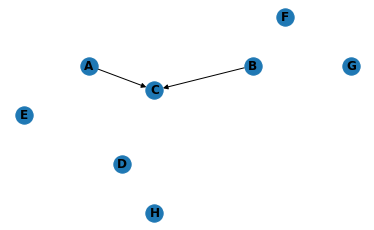

In [ ]:
plt.figure(figsize=(5, 3))
nx.draw(G3, pos=nodes_pos2, with_labels=True, font_weight='bold')

In [ ]:
for i in triples:
  if G3.has_edge(i[0],i[1]) and G2.has_edge(i[1],i[2]) and not G3.has_edge(i[2],i[1]):
    G3.add_edges_from([(i[1],i[2])])

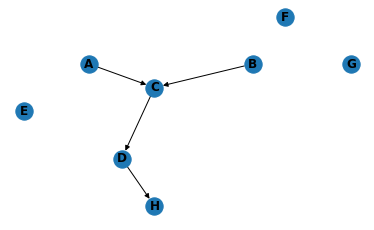

In [ ]:
plt.figure(figsize=(5, 3))
nx.draw(G3, pos=nodes_pos2, with_labels=True, font_weight='bold')

**Now we have a graph with the directions from the PC algorithm and the rest of the orientations are not unique and they will be in the same Markov class as the graph in the model because they have the same skeleton + the same colliders**


So the 2 graphs below are in the same Markov class:

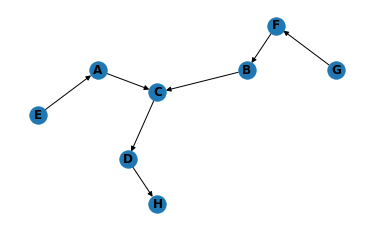

In [ ]:
G3.add_edges_from([("F","B"),("G","F"),("E","A")])
plt.figure(figsize=(5, 3))
nx.draw(G3, pos=nodes_pos2, with_labels=True, font_weight='bold')

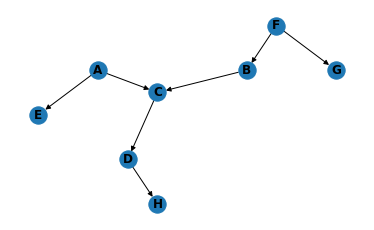

In [ ]:
G3.remove_edges_from([("F","B"),("G","F"),("E","A")])
G3.add_edges_from([("F","B"),("F","G"),("A","E")])
plt.figure(figsize=(5, 3))
nx.draw(G3, pos=nodes_pos2, with_labels=True, font_weight='bold')